# Rogun HPP - Surface DXF to Nodes in CSV

... REVISE FOR GEOLOGICAL SURFACES ...

This procedure prepares geological surface data from a CAD DXF and is intended to provide necessary input to the Hydropower Waterways Decision Support System (Waterways DSS), along with the Basemaps Setup module:
- alignments for feasibilty and siting analysis
- alignments for determing geolocation of project data and for visualizing this.

[Various means of using alignemnt data for hydropower and geotechnical analysis, which includes data analysis and visualization, have been reviewed:
1. export geometry from CAD (often Civil3d) using a suitable geospatial format and use python procedures for analysis: geojson(3d) would be ideal but is hot supported; LandXML is supported from Civil3d, but we found this to be complicated and fragile; DXF export is the time-proven fallback solution 
2. perform analysis inside of CAD (probably Civil3d), most probably as plug-in developed using C++ API: not a realistic scenario in most engineering consultancy offices
3. perform analysis from CAD ((probably Civil3d) using bindings to an external software development environment (pytprobably hon): solution does not yet exist and bindings to CAD/Civil3d are considered to have a steep learning curve.

The only practical choice at this time is 1.] (move this text to Notes)

The procedure described here is one of three procedrues foreseen for preparing alignment data for the Waterways DSS:
1. select alignment geometry from CAD (or e.g. Sketchup) and export as DXF, and process with grass and python for alignment definition
2. prepare alignment with surveying software (I am using Traverse PC), using alignment data from drawings and reports
3. digitize alignments from project layouts (e.g. as prepared by Basemap Setup) together with profile data, using QGIS, and export alignment as CSV (or alternatively query coordinates at tangent points along alignment and write into a CVS data file).

This procedure adresses in particular line data exported as DXF from Sketchup:
- "alignment" polyline data (main aim)
- wire mesh line data (just as a preliminary exploration).

The exported line data can in principle be either LINE or POLYLINE. My experience however is that Sketchup exports polylines as unordered LINE data, e.g. the exported polyline segments are not in topological order. It may be possible to group or weld lines to form a polyline (plug-in?) in Sketchup, but this would need to be robust in all edge cases. It seems easier to just allow for unordered line data as input to grass and to order the line data with grass.

Wire mesh data is processed with grass to LINESTRINGS, which remain as topologically unordered line segments. As the purpose of wire mesh data is only for visulaization of structures, unordered line segments will be suitable.

"Alignment" polyline data exported from Sketchup as unordered LINE data must be processed to produce an ordered sequence of vertices along the alignment polyline. This works explores processing the "alignment" polyline data in grass.

In [1]:
# ToDo

#  'layer' -> 'surface' (sometimes - needs review)
#  surface names to be as 'layer_1' -> 'sandstone_K1ob2'
#  check bottom elevation of surface != 0 (=0 implies artifacts in export)
#  check nr of edge/vertice entities in Sketchup vs grass lines/points


#  all data (e.g. file names) as variables
#  markdown titles
#  comments with explanations of code / grass methods
#  this example use grass script, do again with pygrass defining class & methods (to go into API later)


## grass setup for project

In [2]:
# set up Python for GRASS GIS
import os
import sys
import subprocess
from IPython.display import Image

# set up GRASS GIS runtime environment
gisbase = subprocess.check_output(["grass", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
os.environ['GRASS_FONT'] = 'sans'
os.environ['GRASS_OVERWRITE'] = '1'  #overwrite existing maps
sys.path.append(os.path.join(gisbase, "etc", "python"))

# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

# import GRASS GIS
import grass.script as gs
import grass.script.setup as gsetup
from grass.script import core as grass

# for pygrass
from grass.pygrass.modules.shortcuts import raster as r, vector as v, general as g, display as d

from subprocess import PIPE

# further setup for GRASS GIS 
gs.set_raise_on_error(True)
#gs.set_capture_stderr(True)  #might be Python 2 vs 3 issue (unsure if Python 3 required for this Notebook)

# additional imports
import numpy as np

In [3]:
# https://grasswiki.osgeo.org/wiki/GRASS_Python_Scripting_Library
# GRASS Python Scripting Library
# How to retrieve error messages from read_command():

def read2_command(*args, **kwargs):                                                 #rename to e.g. read_grass
   kwargs['stdout'] = grass.PIPE
   kwargs['stderr'] = grass.PIPE
   ps = grass.start_command(*args, **kwargs)
   return ps.communicate()

In [4]:
# create a mapset (mapset does not already exist)
# should only do once (but will report error and exit if already exists)

# dir /home/kaelin_joseph/projects/RogunHEP/grassdata  should already exist
!grass -c EPSG:3857 /home/kaelin_joseph/projects/RogunHPP/grassdata/RogunHPP -e
# should use grass scipt                                                                             ToDo JK !!    

# define all parameters separately                                                                   ToDo JK !!
#EPSG:3857  #WGS84 Pseudo Mercator

Cleaning up temporary files...
Creating new GRASS GIS location/mapset...
ERROR: Failed to create new location. The location <RogunHPP> already exists.
Exiting...


In [5]:
# open mapset
rcfile = gsetup.init(gisbase, 
         "/home/kaelin_joseph/projects/RogunHPP/grassdata",
         "RogunHPP/", "PERMANENT")

In [6]:
# check grass env
print grass.gisenv()

{'MAPSET': 'PERMANENT', 'GISDBASE': '/home/kaelin_joseph/projects/RogunHPP/grassdata', 'LOCATION_NAME': 'RogunHPP/'}


In [7]:
# check projection info
read2_command('g.proj', flags = 'jf')

('+proj=merc +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +no_defs +a=6378137 +rf=298.257223563 +towgs84=0.000,0.000,0.000 +to_meter=1\n',
 '')

In [8]:
#check mapsets
grass.mapsets()

['PERMANENT']

In [9]:
# set grass region for project
n,s,e,w = 24797, 20796, 28600, 25597  #bounds of topog
g.region(n=n,s=s,e=e,w=w, res=5)

Module('g.region')

In [10]:
# check grass region
print(g.region(flags='p',stdout_=PIPE).outputs.stdout.decode())

projection: 99 (Mercator)
zone:       0
datum:      wgs84
ellipsoid:  wgs84
north:      24797
south:      20796
west:       25597
east:       28600
nsres:      5.00125
ewres:      4.99667221
rows:       800
cols:       601
cells:      480800



In [11]:
# remove any existing raster masks
#  make this part of basemap class initiation
!r.mask -r

ERROR: No existing MASK to remove


## input data for project

In [12]:
# # define geological surface to be processed
# surface = '/home/kaelin_joseph/projects/RogunHPP/data/in/fault_3.dxf'

# define geological layers to be processed
# layers and litholgies must be ordered from top to bottom
# litholgies correspond to downside litholgy of a layer
layers = [1, 3, 5]
lithologies = ['sandstone_K1ob2', 'siltstone_K1ob1', 'sandstone_K1kz']

surfaces, surfaces_vect = [], []
surfaces_points, surfaces_points_csv = [], []
surfaces_rast, surfaces_rast_ = [], []

for layer in layers:
    surfaces.append('/home/kaelin_joseph/projects/RogunHPP/data/in/layer_'+str(layer)+'.dxf')
    surfaces_vect.append('surface_'+str(layer))
    surfaces_points.append('surface_points_'+str(layer))
    surfaces_points_csv.append('/home/kaelin_joseph/projects/RogunHPP/data/out/layer_'+str(layer)+'.csv')
    surfaces_rast.append('surface_rast_'+str(layer))
    surfaces_rast_.append('surface_rast__'+str(layer))
    
# define required output data files for project
# refactor to provide names for each specific layer using string addition                           #ToDo jjk
# surface_vect = 'surface'
# surface_points = 'surface_points'
# surface_points_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/Surface_points.csv'

In [13]:
surfaces

['/home/kaelin_joseph/projects/RogunHPP/data/in/layer_1.dxf',
 '/home/kaelin_joseph/projects/RogunHPP/data/in/layer_3.dxf',
 '/home/kaelin_joseph/projects/RogunHPP/data/in/layer_5.dxf']

## import DXF data to grass vector (lines)

In [14]:
# read dxf data

# 'surfaces' is a list containing geological surfaces
# 'surfaces_vect' is a list containing names of grass vector data
for surface, output in zip(surfaces, surfaces_vect):
    print(surface)
    out = read2_command("v.in.dxf", input=surface, output=output, flags='e')
    print(out[1].decode())    
    
# pattern for 'printing grass output nicely
#   decode must be applied to each member of tuple
#   [0] -> stdout
#   [1] -> stderr
#   above are according to doc, however it seems that [1] is where all output is

/home/kaelin_joseph/projects/RogunHPP/data/in/layer_1.dxf
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  11  22  33  44  55  66  77  88  99 100
Following DXF layers found:
Layer 1: 0
Building topology for vector map <surface_1@PERMANENT>...
Registering primitives...
315 primitives registered
712 vertices registered
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  

In [15]:
# set grass region from vector data bounds
#   set region using 'surfaces_vect[0]'
read2_command('g.region', vector=surfaces_vect[0])

('', '')

In [16]:
# check grass region
print(g.region(flags='p',stdout_=PIPE).outputs.stdout.decode())

projection: 99 (Mercator)
zone:       0
datum:      wgs84
ellipsoid:  wgs84
north:      23474.41015625
south:      22924.75
west:       27539.02929688
east:       27868.3515625
nsres:      4.99691051
ewres:      4.9897313
rows:       110
cols:       66
cells:      7260



In [17]:
def report_vect(surface_vect):
# report of vector data imported from dxf
#  comment out individual reporting as desired

    # report imported DXF layers
    print(surface_vect)
    print(read2_command("v.info", map=surface_vect, layer='-1', verbose=True)[0].decode()) 

#     # report entities in imported DXF layers
#     #   adjust range as desired
#     out = read2_command("v.db.select", map=surface_vect)[0].splitlines()
#     for line in range(0,4):
#         print(out[line])

#     # report categories in imported DXF layers
#     print('\n')
#     print(read2_command("v.category", input=surface_vect, layer='-1', option='report', verbose=True)[0].decode()) 

#     # report coordinatesin imported DXF layers
#     #   adjust range as desired
#     out = read2_command("v.report", map=surface_vect, layer='-1', option='coor', verbose=True)[0].splitlines()
#     for line in range(0,1):
#         print(out[line])

#     # report on attributes stored in grass sqlite database
#     print('\n')
#     print(read2_command("v.db.connect", map=surface_vect, flags='c', verbose=True)[0].decode()) 
    
for surface_vect in surfaces_vect:
    report_vect(surface_vect)

surface_1
 +----------------------------------------------------------------------------+
 | Name:            surface_1                                                 |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           surface_1                                                 |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native    

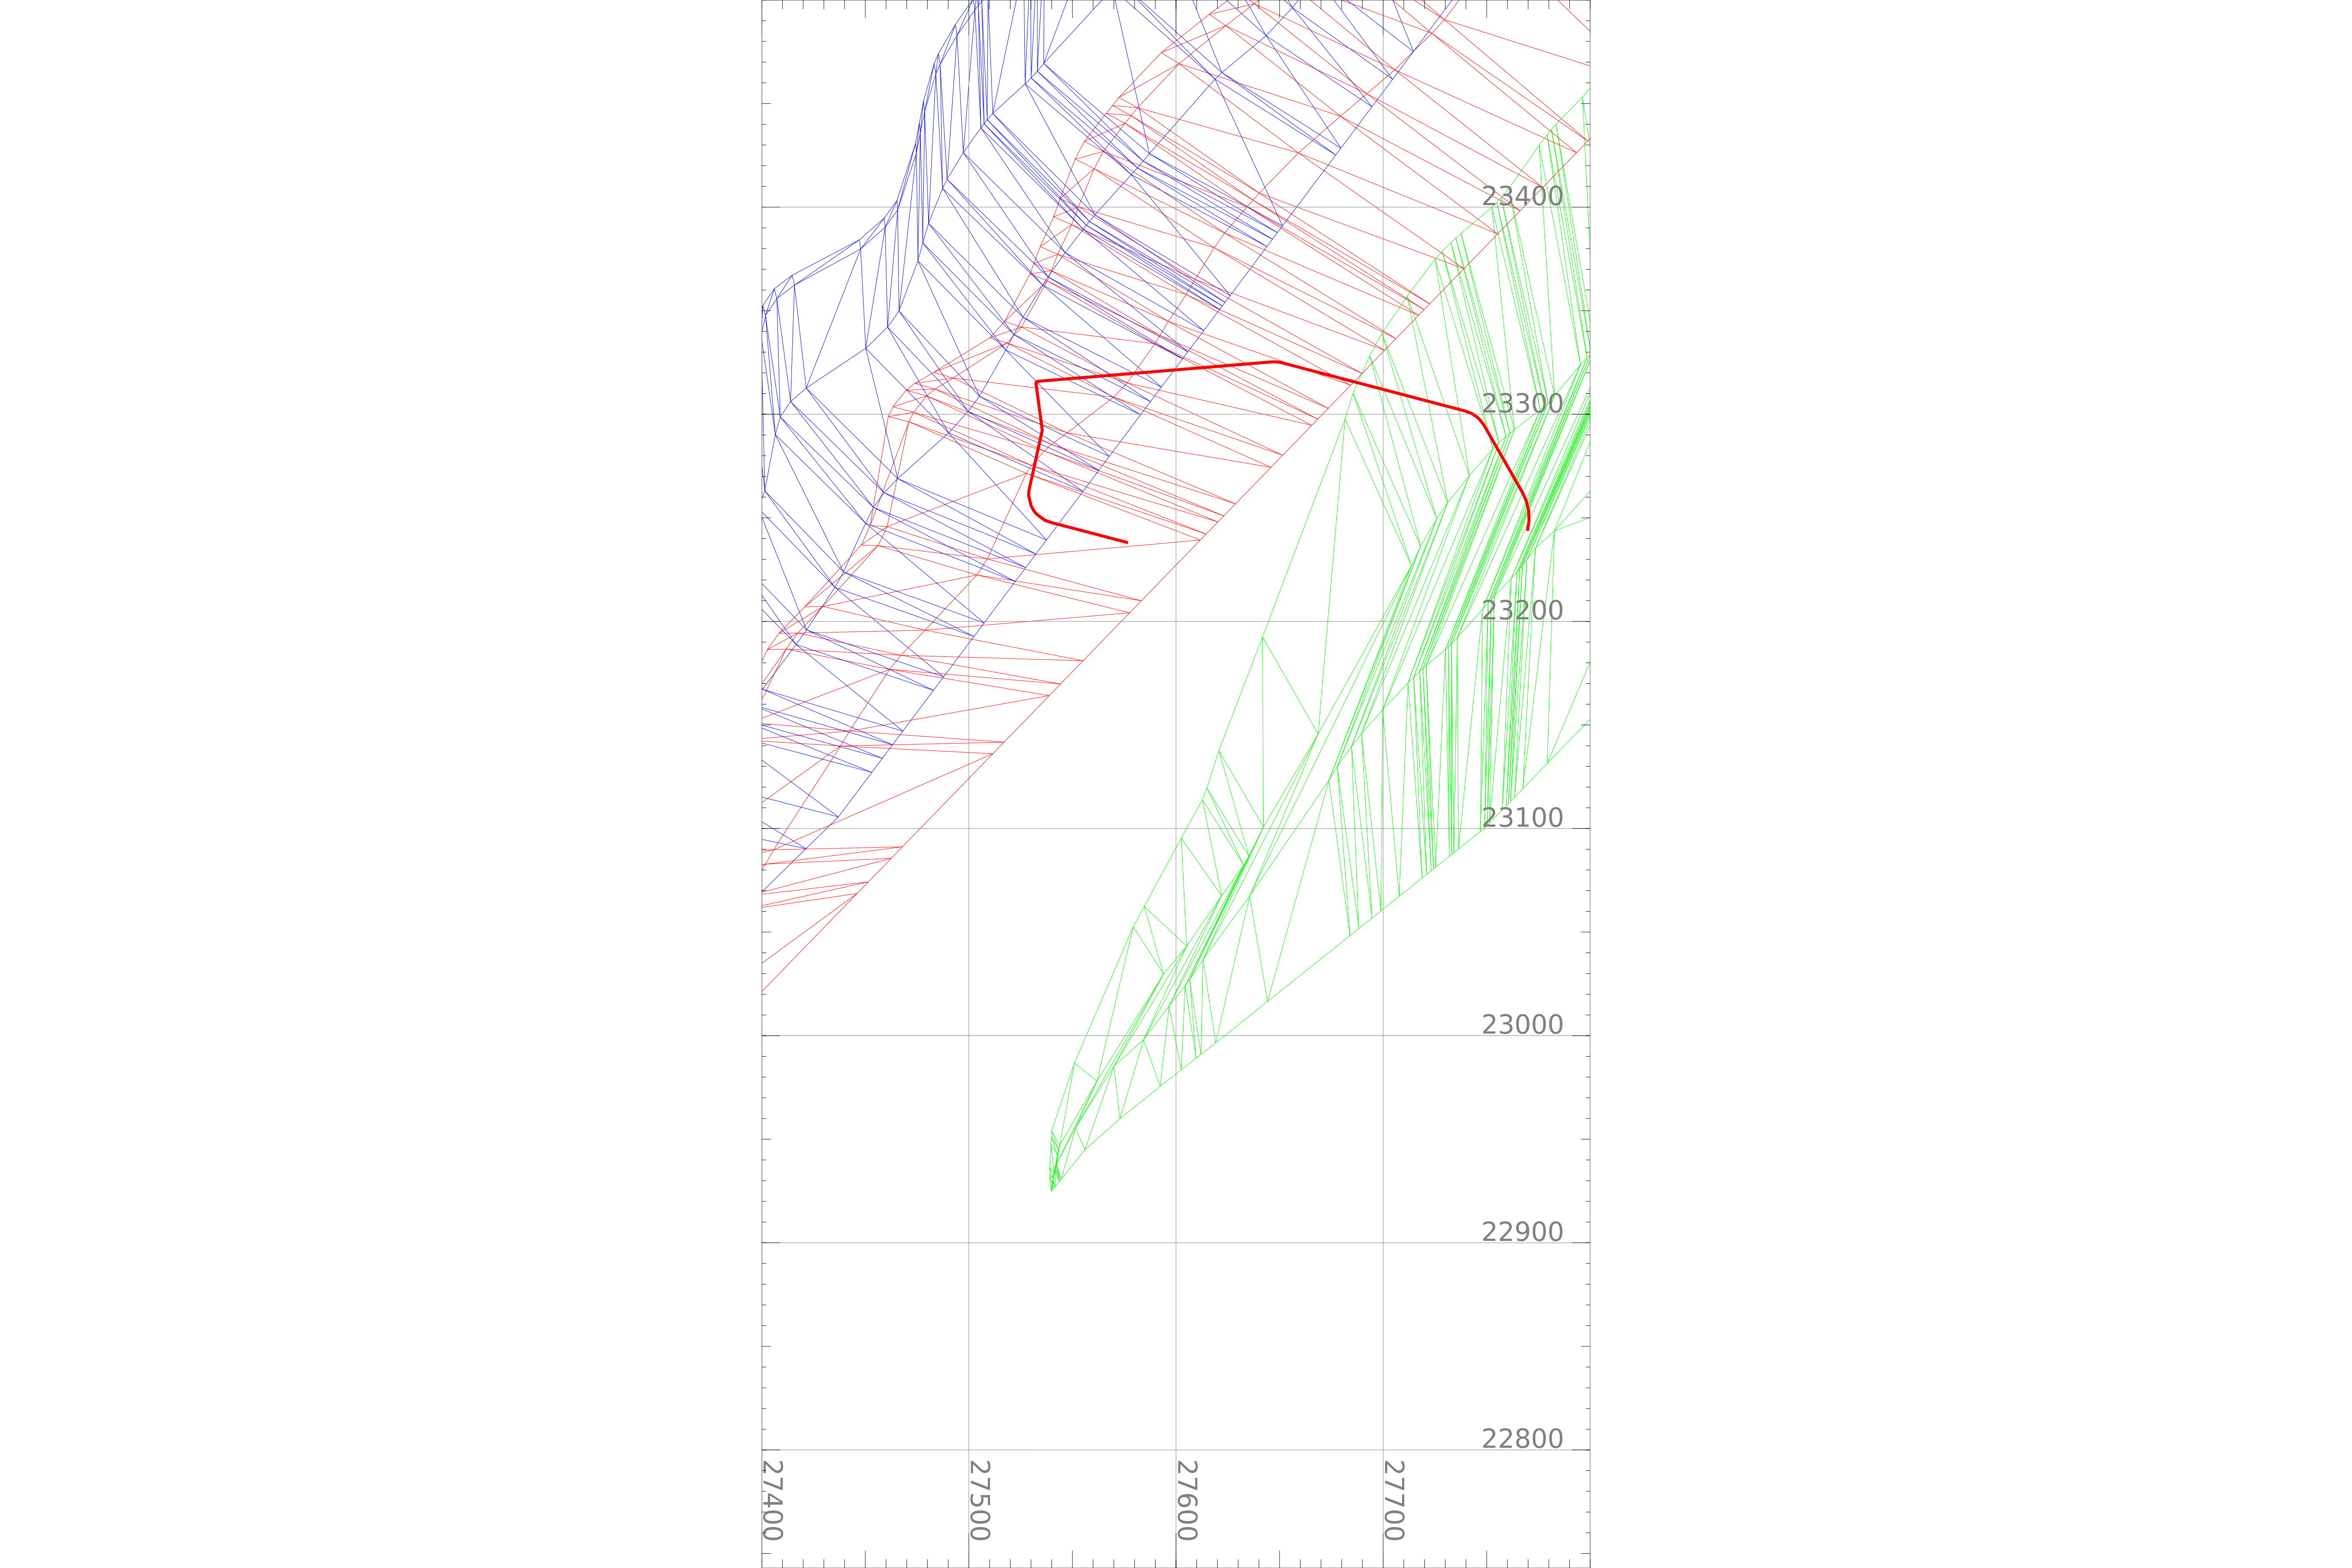

In [47]:
# view and check imported topography
#   view selected surface n 'surfaces_vect[n]'
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=surfaces_vect[0], color='green')
read2_command("d.vect", map=surfaces_vect[1], color='red')
read2_command("d.vect", map=surfaces_vect[2], color='blue')

# display Drainage Gallery DG3 alignment
read2_command('d.vect', map='alignment_dg3_cleaned', color='red', width=7)

read2_command("d.grid", size=100, fontsize=60)[0]

Image(filename="map.png")

## extract points (unordered) from imported DXF vector data

In [19]:
# extract points from vector data from dxf to grass points vector data

# 'surfaces_vect' is a list containing names of grass vector data
# 'surfaces_points' is a list containing grass points vector data
for surface_vect, surface_points in zip(surfaces_vect, surfaces_points):
    out = read2_command("v.to.points", input=surface_vect, output=surface_points)     
    print(out[1].decode())

         overwritten
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Building topology for vector map <surface_points_1@PERMANENT>...
Registering primitives...
826 primitives registered
826 vertices registered
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
0 areas built
0 isles built
Attaching islands...
Attaching centroids...
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
Number of nodes: 0
Number of primitives: 826
Number of points: 826
Number of lines: 0
Number of boundaries: 0
Number of centroids: 0
Number of areas: 0
Number of isles: 0
v.to.points complete. 826 poin

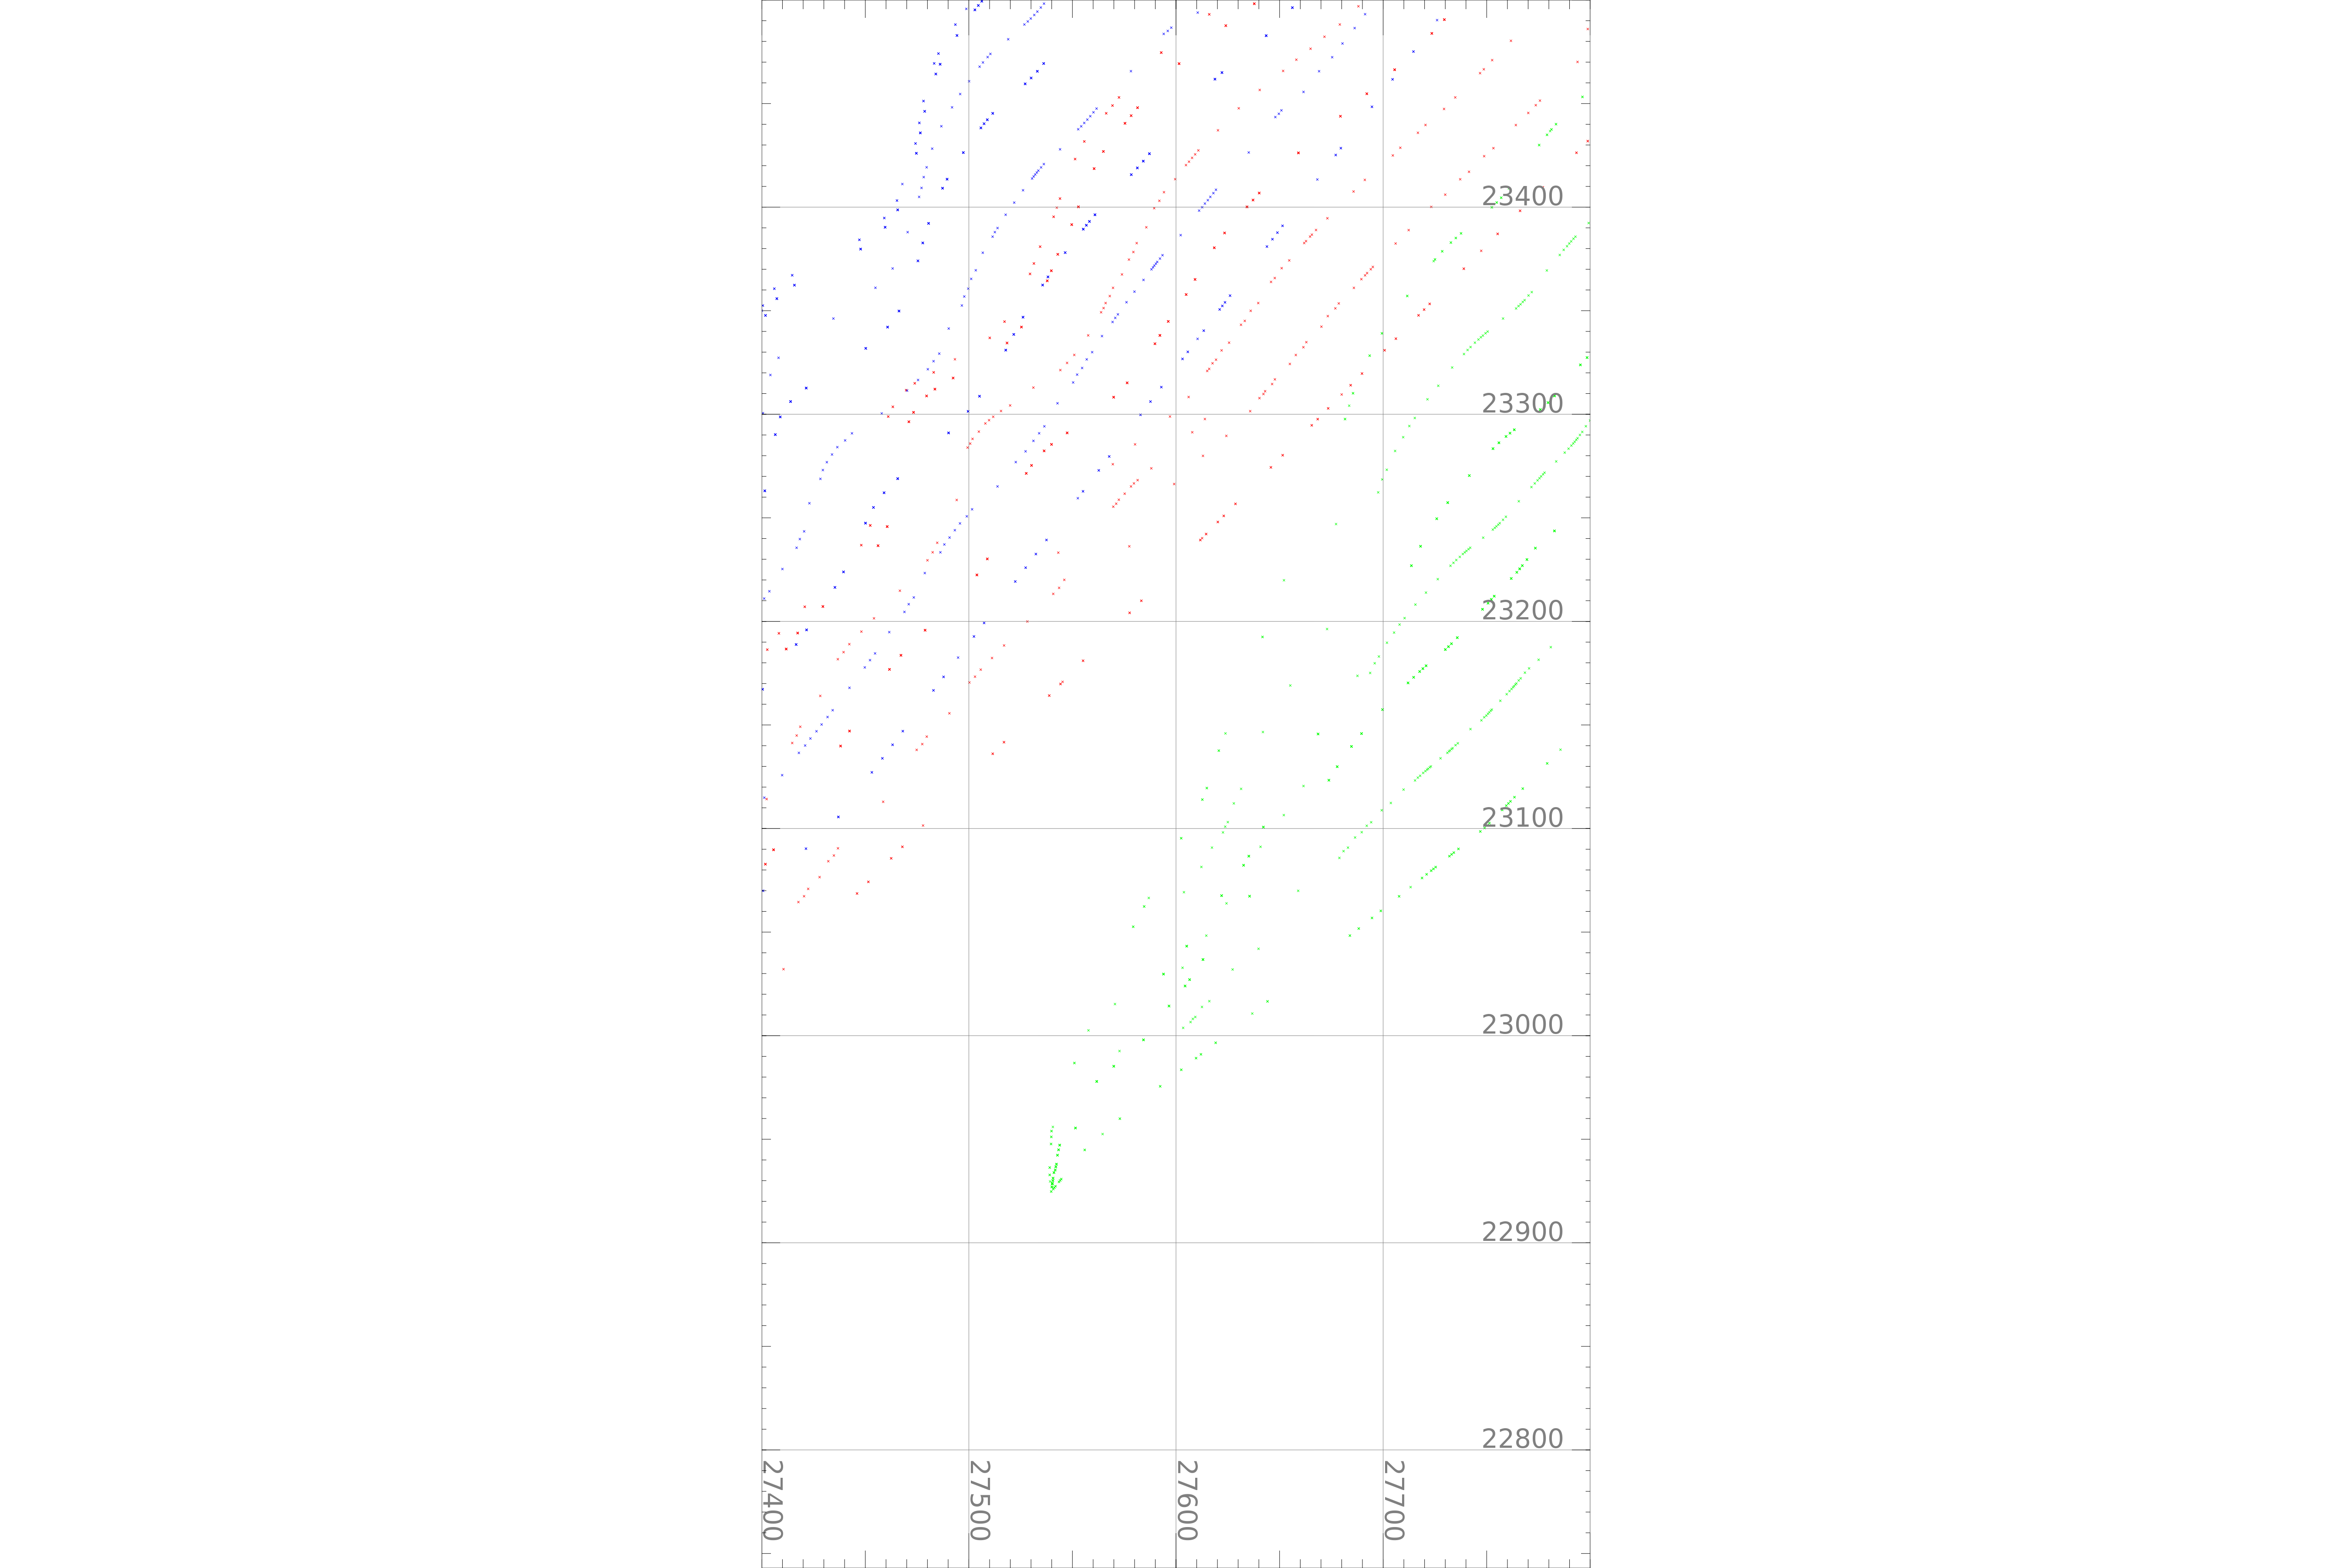

In [48]:
# view and check points topography
#   view selected surface n 'surfaces_vect[n]'
!rm map.png                                                                       #ToDo JK: pythonize
read2_command("d.vect", map=surfaces_points[0], color='green')
read2_command("d.vect", map=surfaces_points[1], color='red')
read2_command("d.vect", map=surfaces_points[2], color='blue')

read2_command("d.grid", size=100, fontsize=60)[0]

Image(filename="map.png")

## write points to CSV data file

In [21]:
# zoom grass region to area of surface of interest
# this is done primarily to minimize edge artifacts (e.g. ill-formed top edge) of a plotly mesh surface

#n,s,e,w = 24797, 20796, 28600, 25597  #bounds of topog

# determine bounds by inspection of plot result
#n,s,e,w = 23500, 20796, 28600, 27400
n,s,e,w = 23500, 22743, 27800, 27400
g.region(n=n,s=s,e=e,w=w, res=10)     #res=5)

Module('g.region')

In [22]:
#!g.region -p3 # ??


In [23]:
#!v.out.ascii  --help

In [24]:
# extract points from grass points vector data to csv data file

# 'surfaces_points' is a list containing grass points vector data    
# 'surfaces_vect' is a list containing csv data file names for surfaces
for surface_points, surface_points_csv in zip(surfaces_points, surfaces_points_csv):
    out = read2_command("v.out.ascii", input=surface_points, type='point', separator=',',
                        layer=-1, output=surface_points_csv, flags='r') 
    print(out[1].decode())    

In [25]:
#!head -5 /home/kaelin_joseph/projects/RogunHPP/data/out/Surface_points.csv

from __future__ import print_function
file = surfaces_points_csv[0]
with open(file, 'r') as f:
#   for line in f:
    for n in range(500):
        line = f.readline()
        print(line, end='')

27539.22070312,22929.609375,1097.01074219
27540.28771934,22928.73616347,1094.39593292
27540.28771934,22928.73616347,1094.39593292
27539.75195312,22924.75,1092.38842773
27540.28771934,22928.73616347,1094.39593292
27540.05824034,22926.98945526,1092.59006436
27540.05824034,22926.98945526,1092.59006436
27539.75195312,22924.75,1092.38842773
27540.05824034,22926.98945526,1092.59006436
27540.73838696,22925.97372564,1090.03484989
27539.02929688,22932.77539062,1098.92358398
27540.28771934,22928.73616347,1094.39593292
27539.02929688,22932.77539062,1098.92358398
27540.62864778,22931.21319484,1095.06018139
27540.62864778,22931.21319484,1095.06018139
27540.28771934,22928.73616347,1094.39593292
27540.62864778,22931.21319484,1095.06018139
27540.05824034,22926.98945526,1092.59006436
27540.62864778,22931.21319484,1095.06018139
27540.26700977,22928.41659155,1092.49878279
27540.26700977,22928.41659155,1092.49878279
27540.05824034,22926.98945526,1092.59006436
27540.26700977,22928.41659155,1092.49878279
27

## rasterize vector surfaces

In [26]:
# define functions used for rastering

def read_grass(*args, **kwargs):                                                                      
    """execute a grass function with error output """                                                       
    kwargs['stdout'] = grass.PIPE                                                                           
    kwargs['stderr'] = grass.PIPE                                                                           
    ps = grass.start_command(*args, **kwargs)                                                               
    # returns a tuple (stderr,stdout)                                                                       
    return ps.communicate()    

def rasterize_vect_using_points(surface_points, surface_rast, 
                                npoints=12, power=2, dbg=1):                                          
    """convert vector topograpy using extracted points to raster dem"""                                     
    
    # convert vect to raster DEM using v.surf.idw (inverse distance weighting interpolation) 
    out = read_grass("v.surf.idw", input=surface_points, 
                     layer='-1', output=surface_rast, npoints=npoints, power=power)             
    print(out[dbg].decode())                                                                                
    print('rasterize_vect_using_points completed')     

In [27]:
# rasterize surfaces from extracted points from dxf data

# 'surfaces_points' is a list containing grass points vector data    
# 'surfaces_vect' is a list containing csv data file names for surfaces
for surface_points, surface_rast in zip(surfaces_points, surfaces_rast):
    rasterize_vect_using_points(surface_points, surface_rast) 

Input vector map <surface_points_1@PERMANENT> is 3D - using z-coordinates
to interpolate
731 points loaded
Interpolating raster map <surface_rast_1> (76 rows, 40 columns)...
   0   2   5   7   9  11  13  15  17  19  21  23  25  27  30  32  34  36  38  40  42  44  46  48  50  52  55  57  59  61  63  65  67  69  71  73  75  77  80  82  84  86  88  90  92  94  96  98 100
v.surf.idw complete.

rasterize_vect_using_points completed
Input vector map <surface_points_3@PERMANENT> is 3D - using z-coordinates
to interpolate
656 points loaded
Interpolating raster map <surface_rast_3> (76 rows, 40 columns)...
   0   2   5   7   9  11  13  15  17  19  21  23  25  27  30  32  34  36  38  40  42  44  46  48  50  52  55  57  59  61  63  65  67  69  71  73  75  77  80  82  84  86  88  90  92  94  96  98 100
v.surf.idw complete.

rasterize_vect_using_points completed
Input vector map <surface_points_5@PERMANENT> is 3D - using z-coordinates
to interpolate
730 points loaded
Interpolating raster map <surfa

In [28]:
for surface_rast, surface_rast_, surface_points in zip(surfaces_rast, surfaces_rast_, surfaces_points):
    
    # define raster mask based on vector data bounds
    # creates a convex hull around points (since no area data in vector data)
    read_grass("r.mask", vector = surface_points) 
    
    out = read_grass("r.resamp.rst", input = surface_rast,                                     
                     elevation = surface_rast_, ew_res=10, ns_res=10) 

    print(out[1].decode())  

Processing all selected output files will require
11.88 KB of disk space for temp files.
Temporarily changing the region to desired resolution ...
Bitmap mask created
Changing back to the original region ...
Percent complete:
   0   3   6   9  12  14  17  20  23  25  28  31  34  37  39  42  45  48  50  53  56  59  62  64  67  70  73  75  78  81  84  87  89  92  95  98 100
dnorm in ressegm after grid before out2= 128.198551 
dnorm in mainc after grid before out1= 128.198551
dnorm in mainc after grid before out2= 128.198551
r.resamp.rst complete.

Processing all selected output files will require
11.88 KB of disk space for temp files.
Temporarily changing the region to desired resolution ...
Bitmap mask created
Changing back to the original region ...
Percent complete:
   0   3   6   9  12  14  17  20  23  25  28  31  34  37  39  42  45  48  50  53  56  59  62  64  67  70  73  75  78  81  84  87  89  92  95  98 100
dnorm in ressegm after grid before out2= 128.198551 
dnorm in mainc after

In [29]:
# mask also affect display
# remove any existing raster masks
!r.mask -r

Raster MASK removed


In [30]:
#print(read_grass("r.info", map='surface_rast_3')[0].decode())
#print(read_grass("r.report", map='surface_rast_3', units='h,p', nsteps=10)[0].decode()) 
print(read_grass("r.univar", map='surface_rast_3')[0].decode()) 

total null and non-null cells: 3040
total null cells: 0

Of the non-null cells:
----------------------
n: 3040
minimum: 860.765
maximum: 1272.03
range: 411.267
mean: 976.021
mean of absolute values: 976.021
standard deviation: 121.953
variance: 14872.4
variation coefficient: 12.4949 %
sum: 2967104.47663722



In [31]:
#print(read_grass("r.info", map='surface_rast_5')[0].decode())
#print(read_grass("r.report", map='surface_rast_5', units='h,p', nsteps=10)[0].decode()) 
print(read_grass("r.univar", map='surface_rast_5')[0].decode()) 

total null and non-null cells: 3040
total null cells: 0

Of the non-null cells:
----------------------
n: 3040
minimum: 788.284
maximum: 1187.49
range: 399.211
mean: 879.638
mean of absolute values: 879.638
standard deviation: 86.8651
variance: 7545.54
variation coefficient: 9.8751 %
sum: 2674098.12540348



         Your current region setting may be too large. Cells displayed on
         your graphics window may be too small for cell category number to
         be visible.
WARNING: MONITOR variable defined, GRASS_RENDER_IMMEDIATE ignored
Using display driver <cairo>...
cairo: collecting to file
'/home/kaelin_joseph/DataOrganizer/jupyter-python/data_analysis/map.png'
cairo: image size 5400x3600


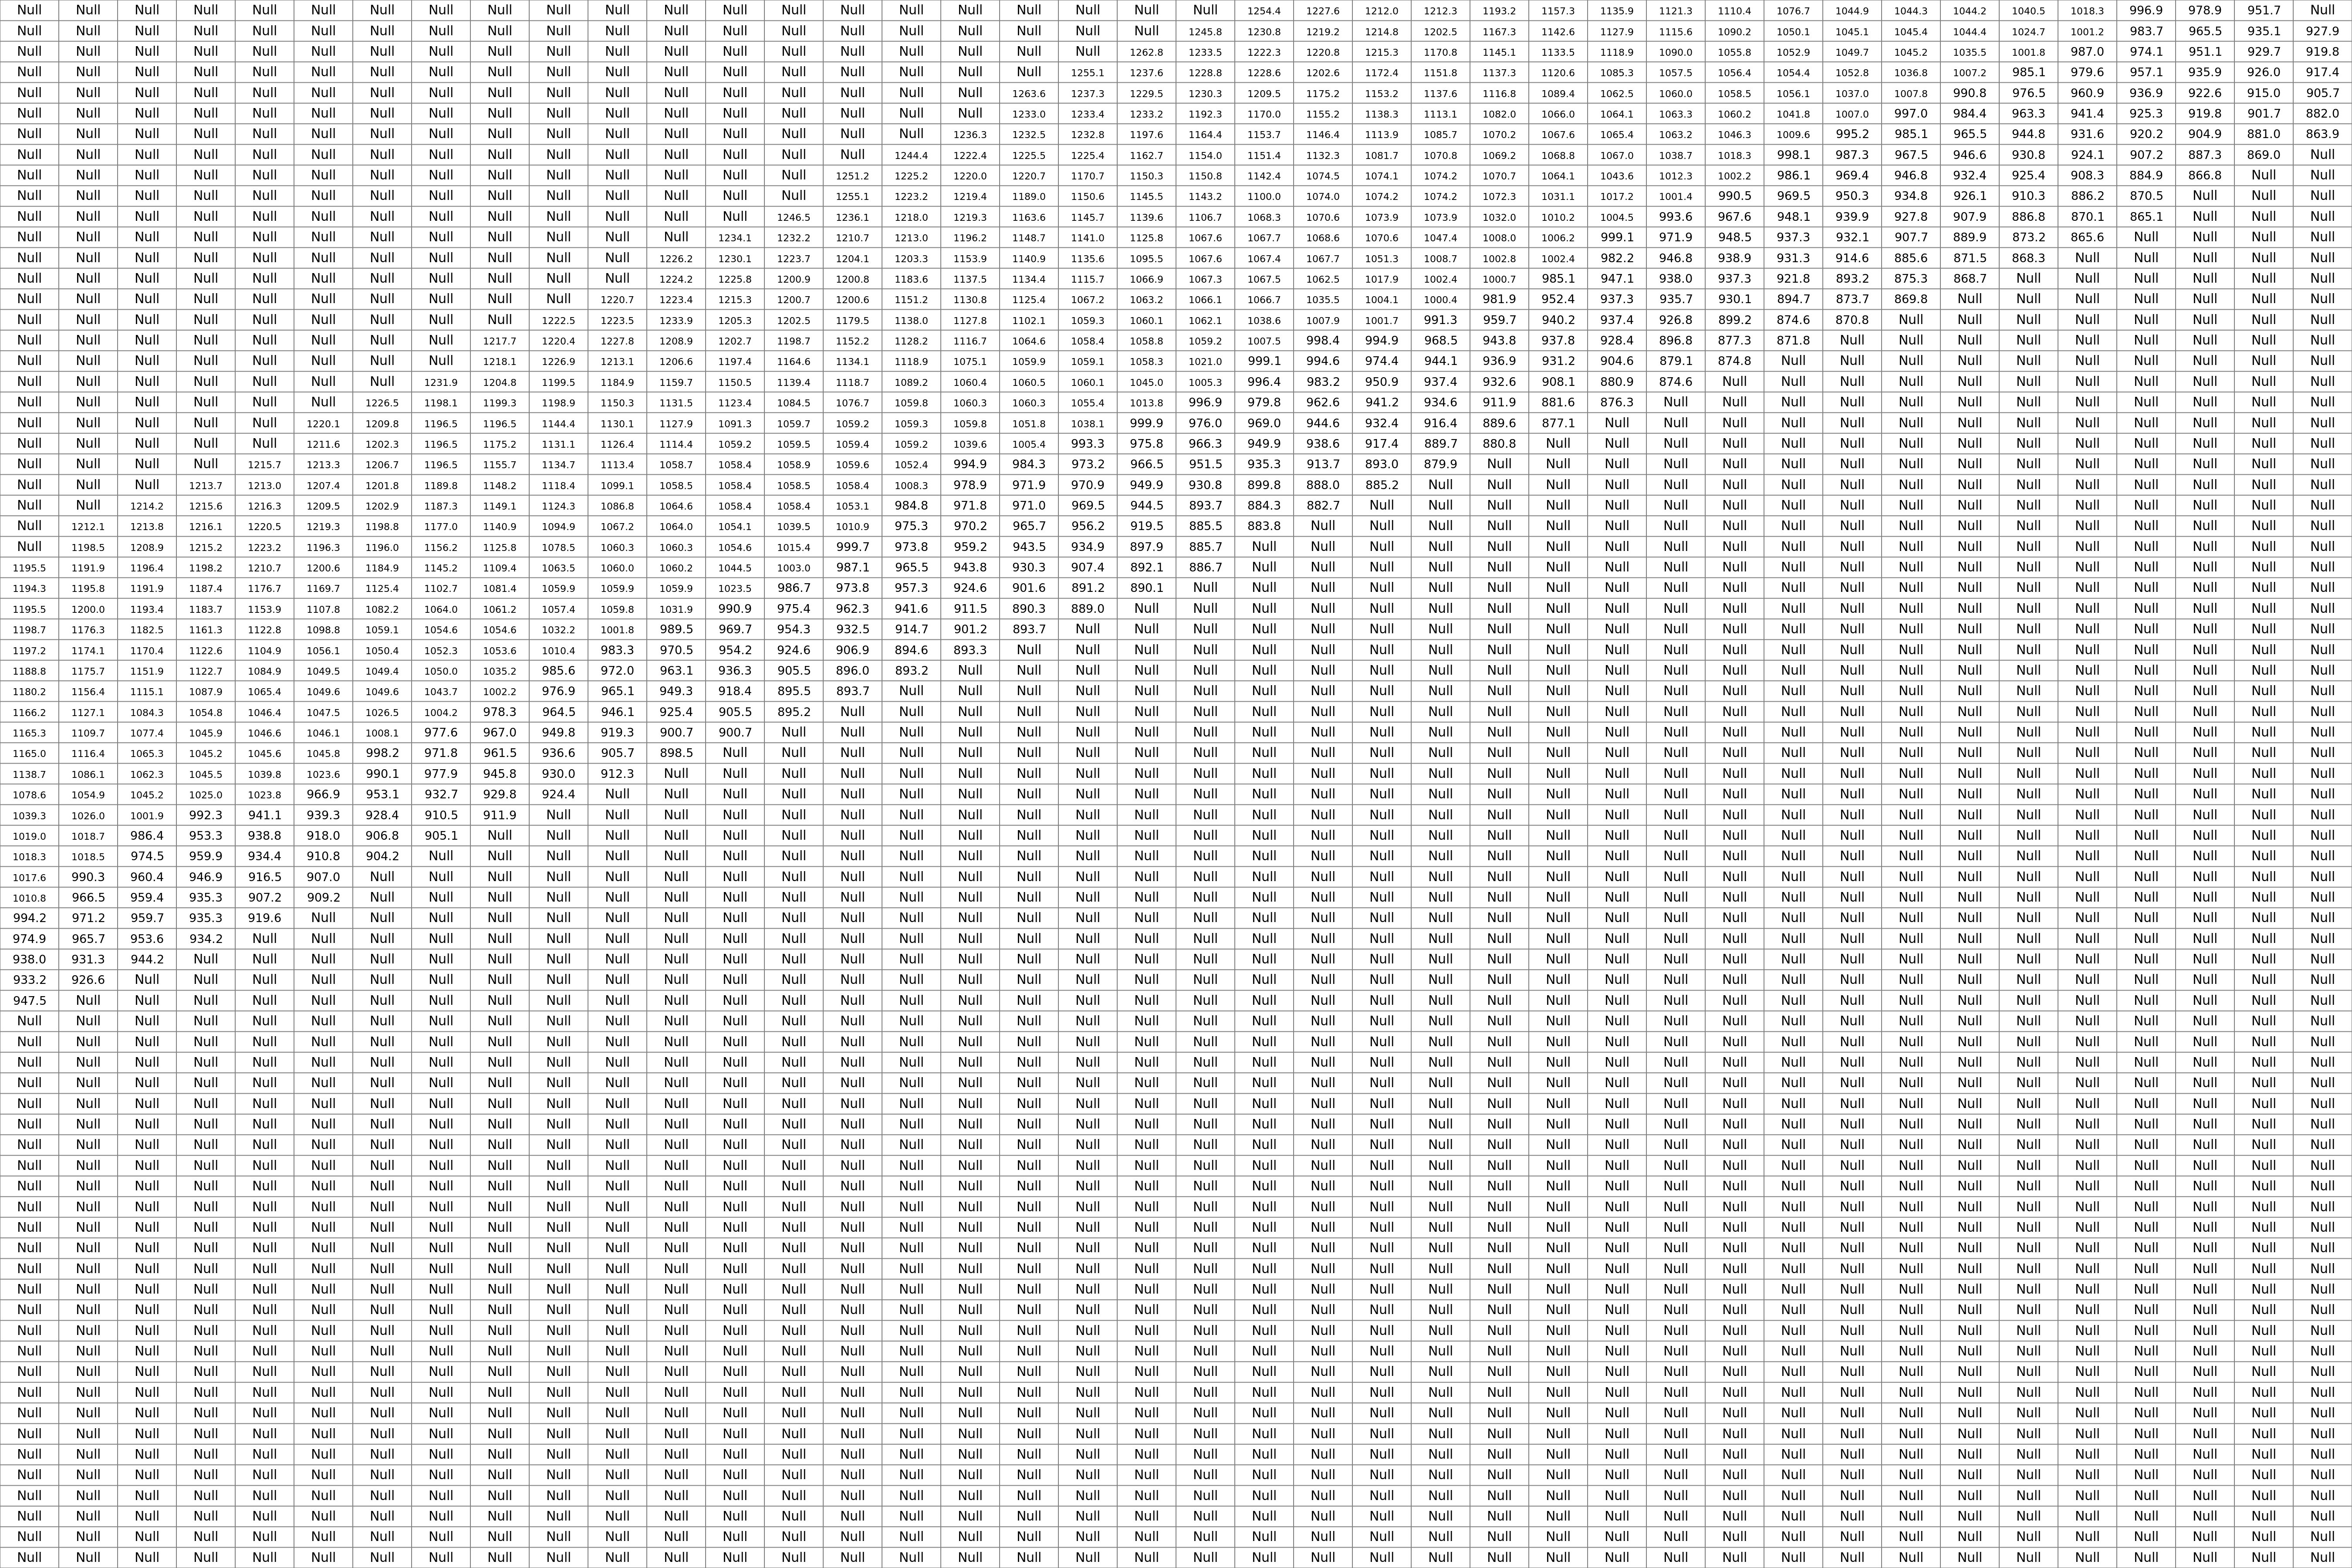

In [32]:
# display topography raster DEM
!rm map.png                                                                                 #ToDo JK: pythonize
read_grass("d.mon", select='cairo', flags='r')  #release current display monitor
read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True)  #outputs, is blank
# read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True, 
#            output='map.pdf')  #outputs, but is blank

#read_grass("d.rast", map='surfaces_rast', bgcolor='white', flags='n')
#read2_command("d.rast", map='surfaces_rast')

# for troubleshooting
#https://grass.osgeo.org/grass77/manuals/d.rast.num.html
!d.rast.num surface_rast__3 --verbose -a  #values look ok (except raster area outside of surface is not null)
####!d.rast.num surface_5 --verbose -a
#!d.rast.leg surfaces_rast --verbose

# show legend and grid, display result
#read_grass("d.legend", raster='surfaces_rast', fontsize='24')[1]
#read_grass("d.grid", size=1000, fontsize=20)[0]
Image(filename="map.png")

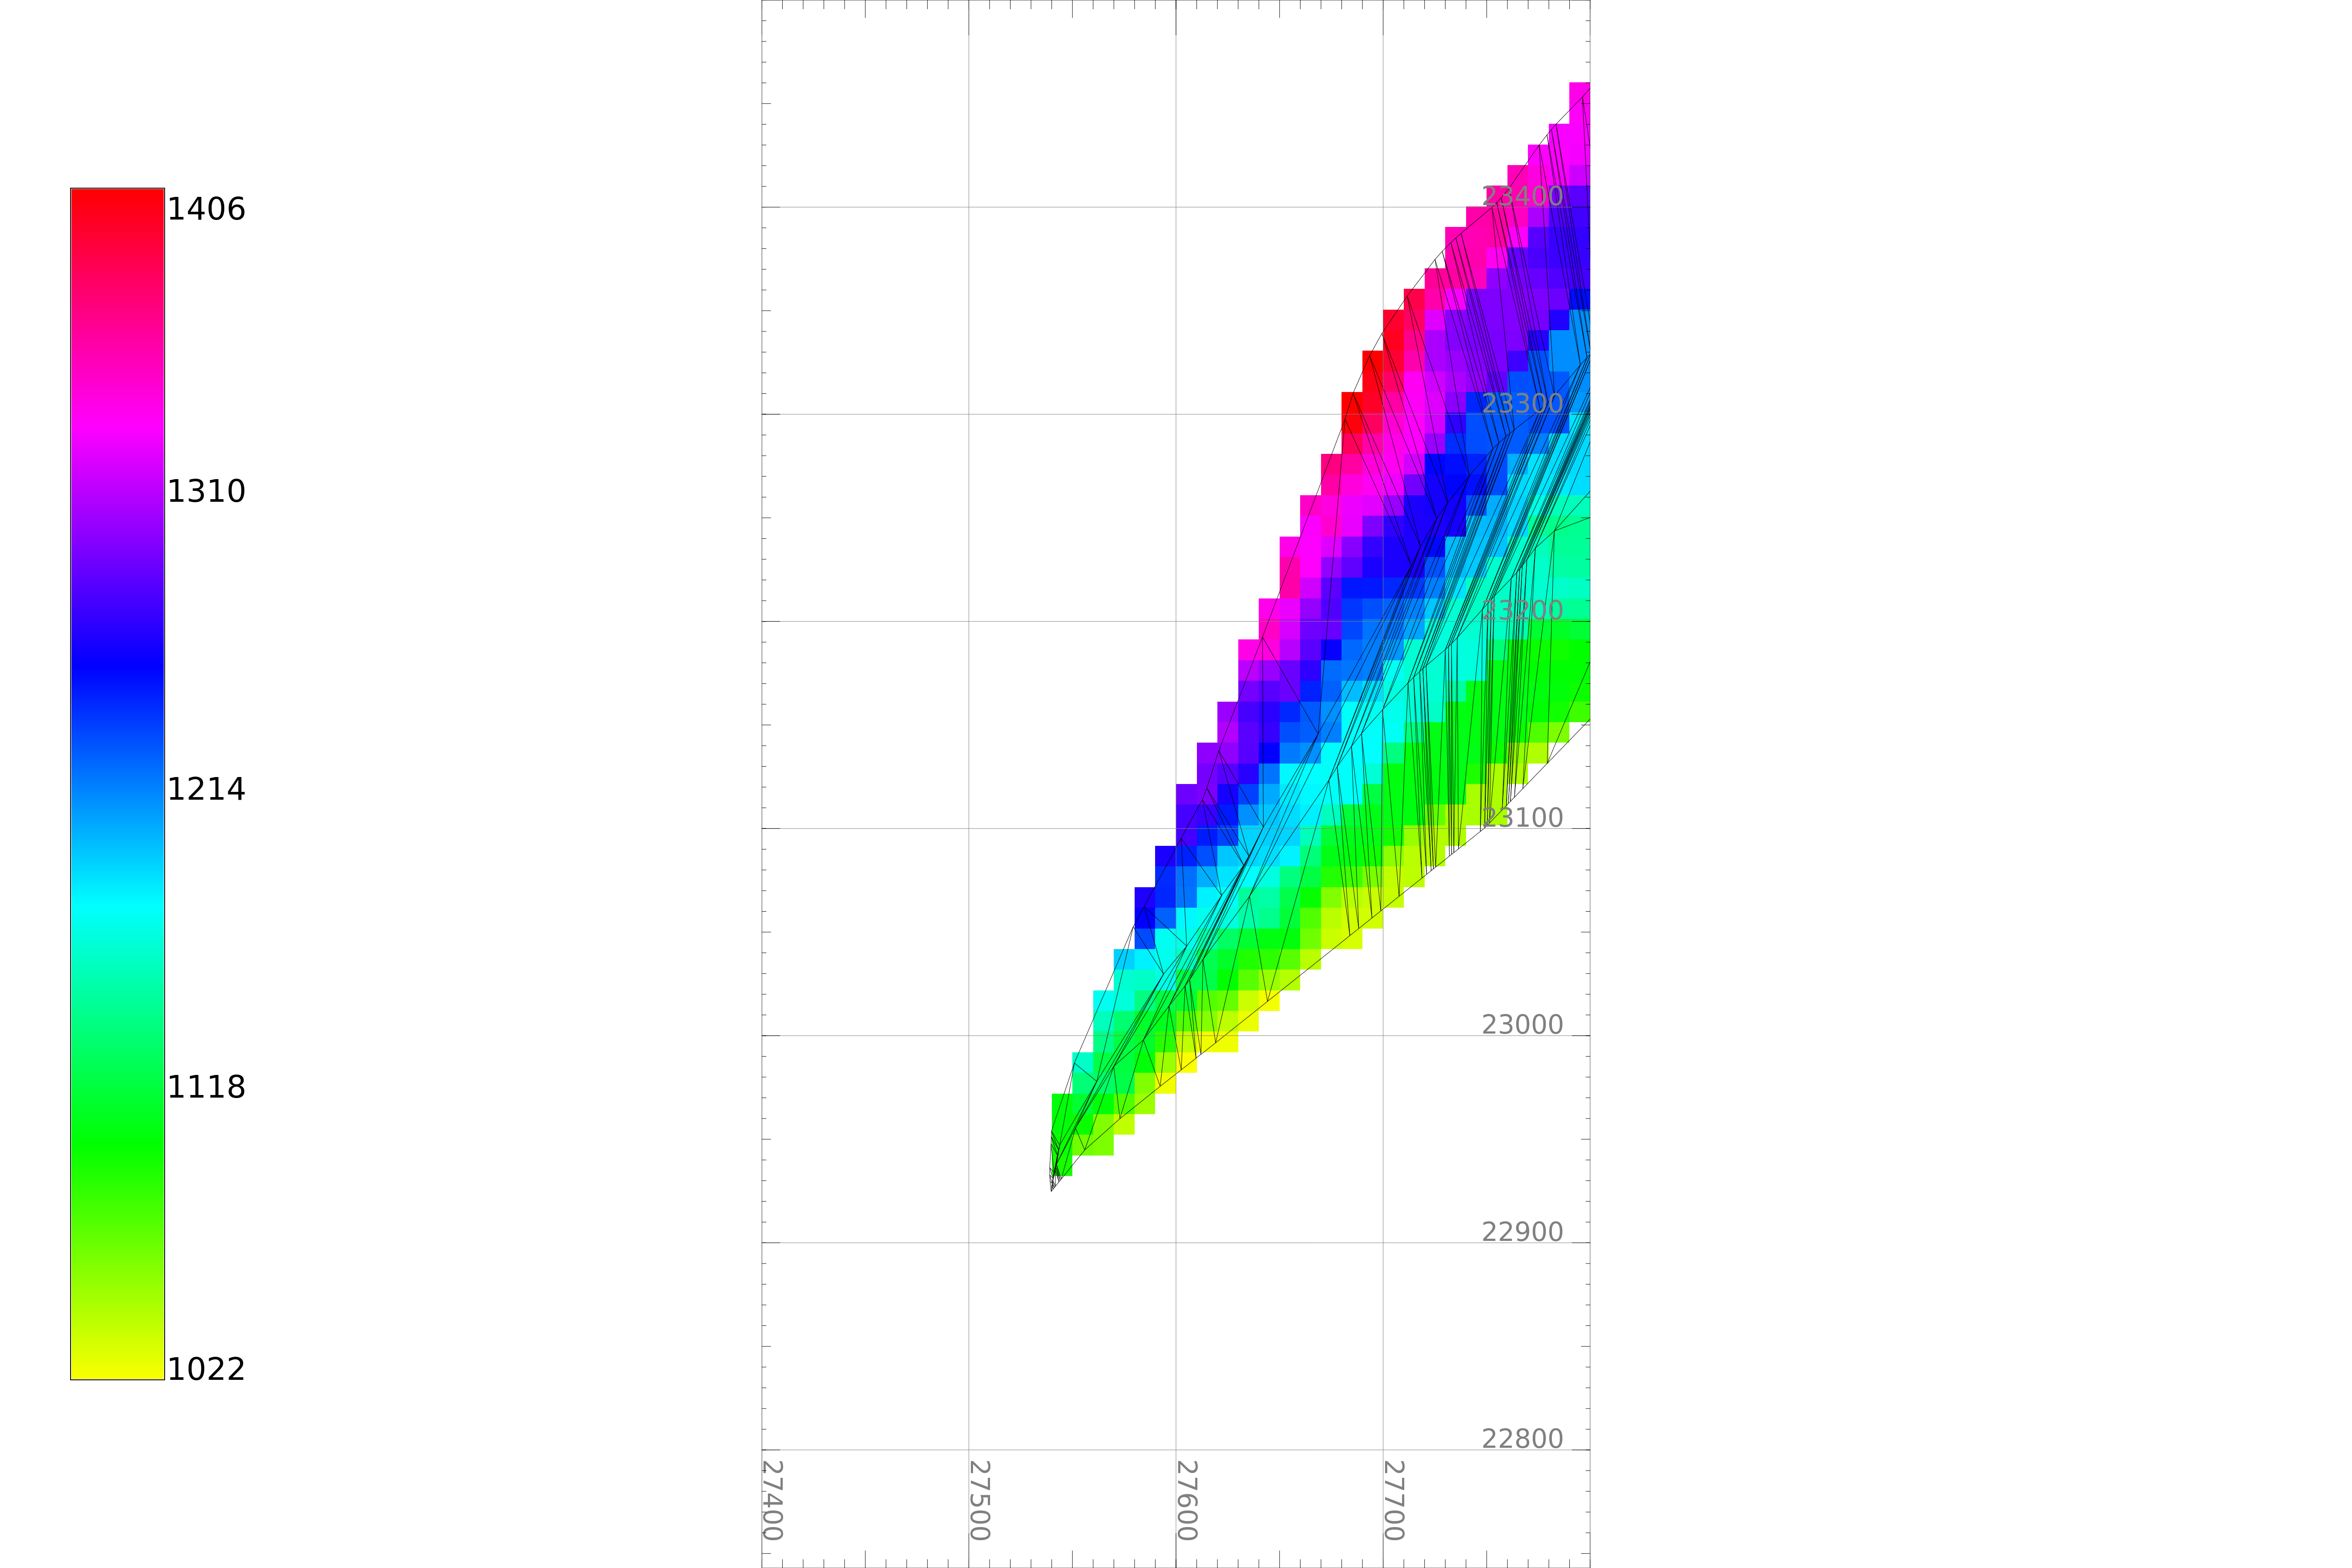

In [33]:
# display topography raster DEM
!rm map.png                                                                                 #ToDo JK: pythonize
read_grass("d.mon", select='cairo', flags='r')  #release current display monitor
read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True)

read_grass("d.rast", map=surfaces_rast_[0], bgcolor='white', flags='n')

read2_command("d.vect", map=surfaces_vect[0], color='black')

#show legend and grid, display result
read_grass("d.legend", raster=surfaces_rast_[0], fontsize='72')[1]
read_grass("d.grid", size=100, fontsize=60)[0]
Image(filename="map.png")

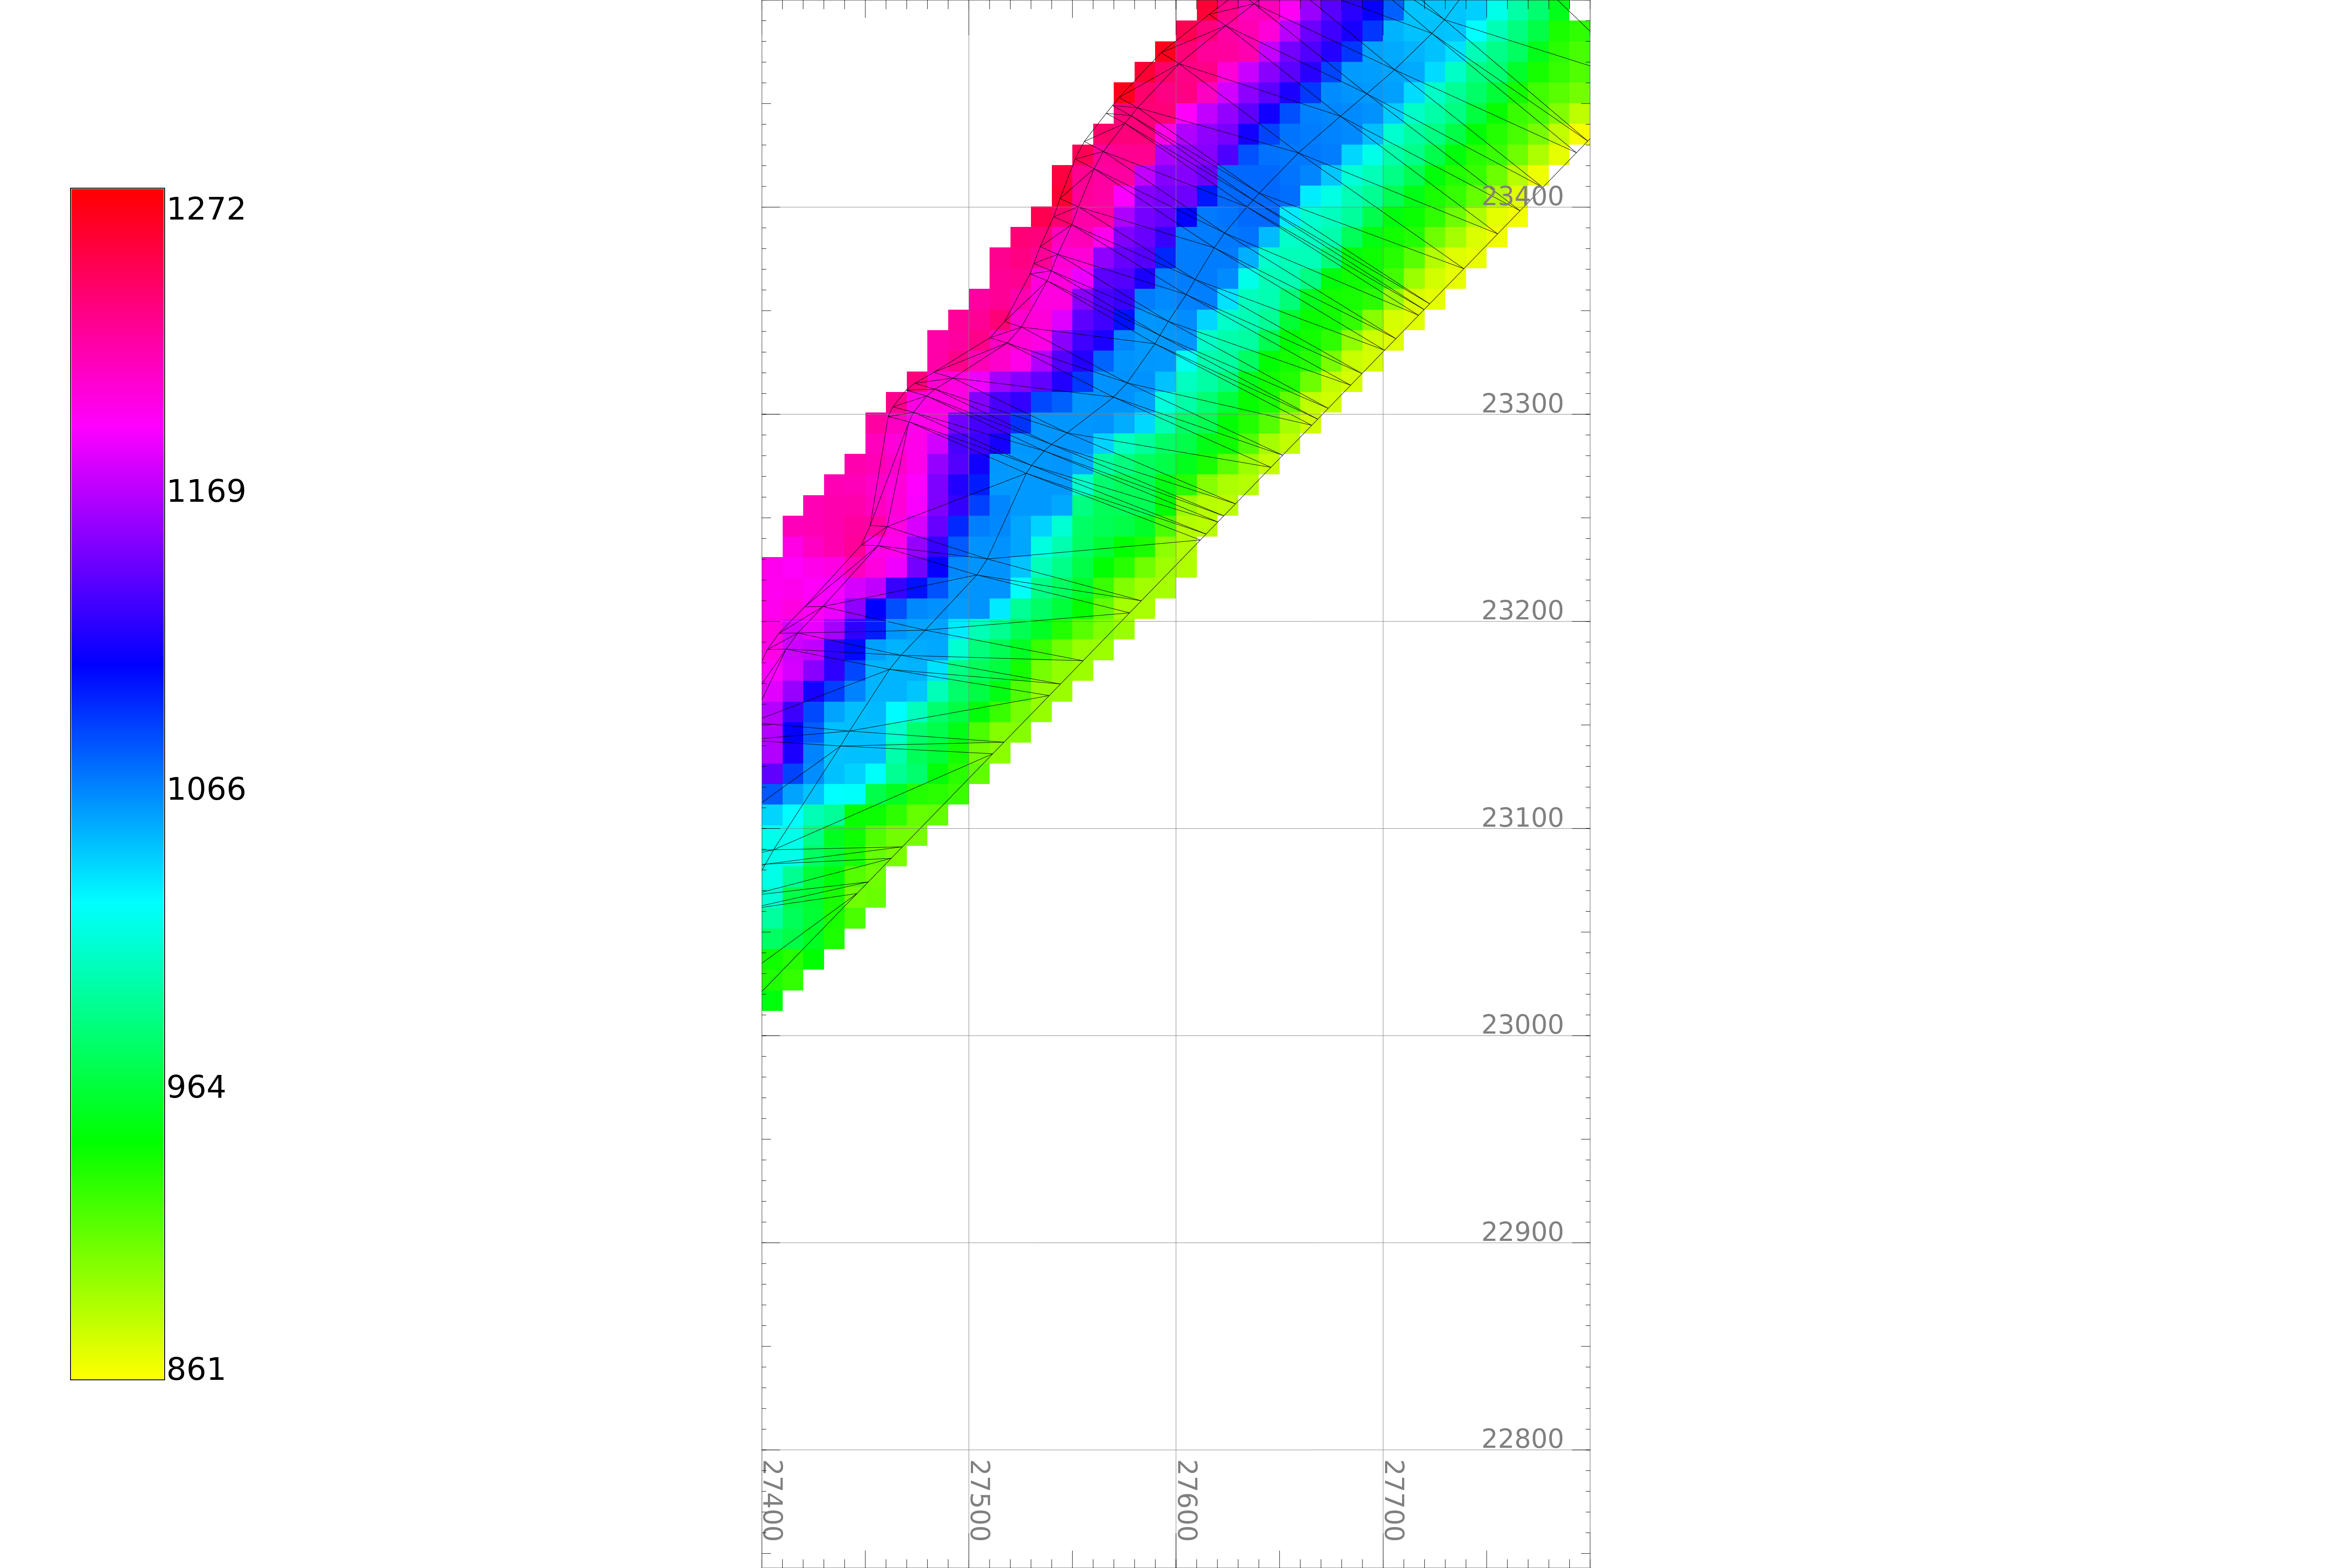

In [34]:
# display topography raster DEM
!rm map.png                                                                                 #ToDo JK: pythonize
read_grass("d.mon", select='cairo', flags='r')  #release current display monitor
read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True)

read_grass("d.rast", map=surfaces_rast_[1], bgcolor='white', flags='n')

read2_command("d.vect", map=surfaces_vect[1], color='black')

#show legend and grid, display result
read_grass("d.legend", raster=surfaces_rast[1], fontsize='72')[1]
read_grass("d.grid", size=100, fontsize=60)[0]
Image(filename="map.png")

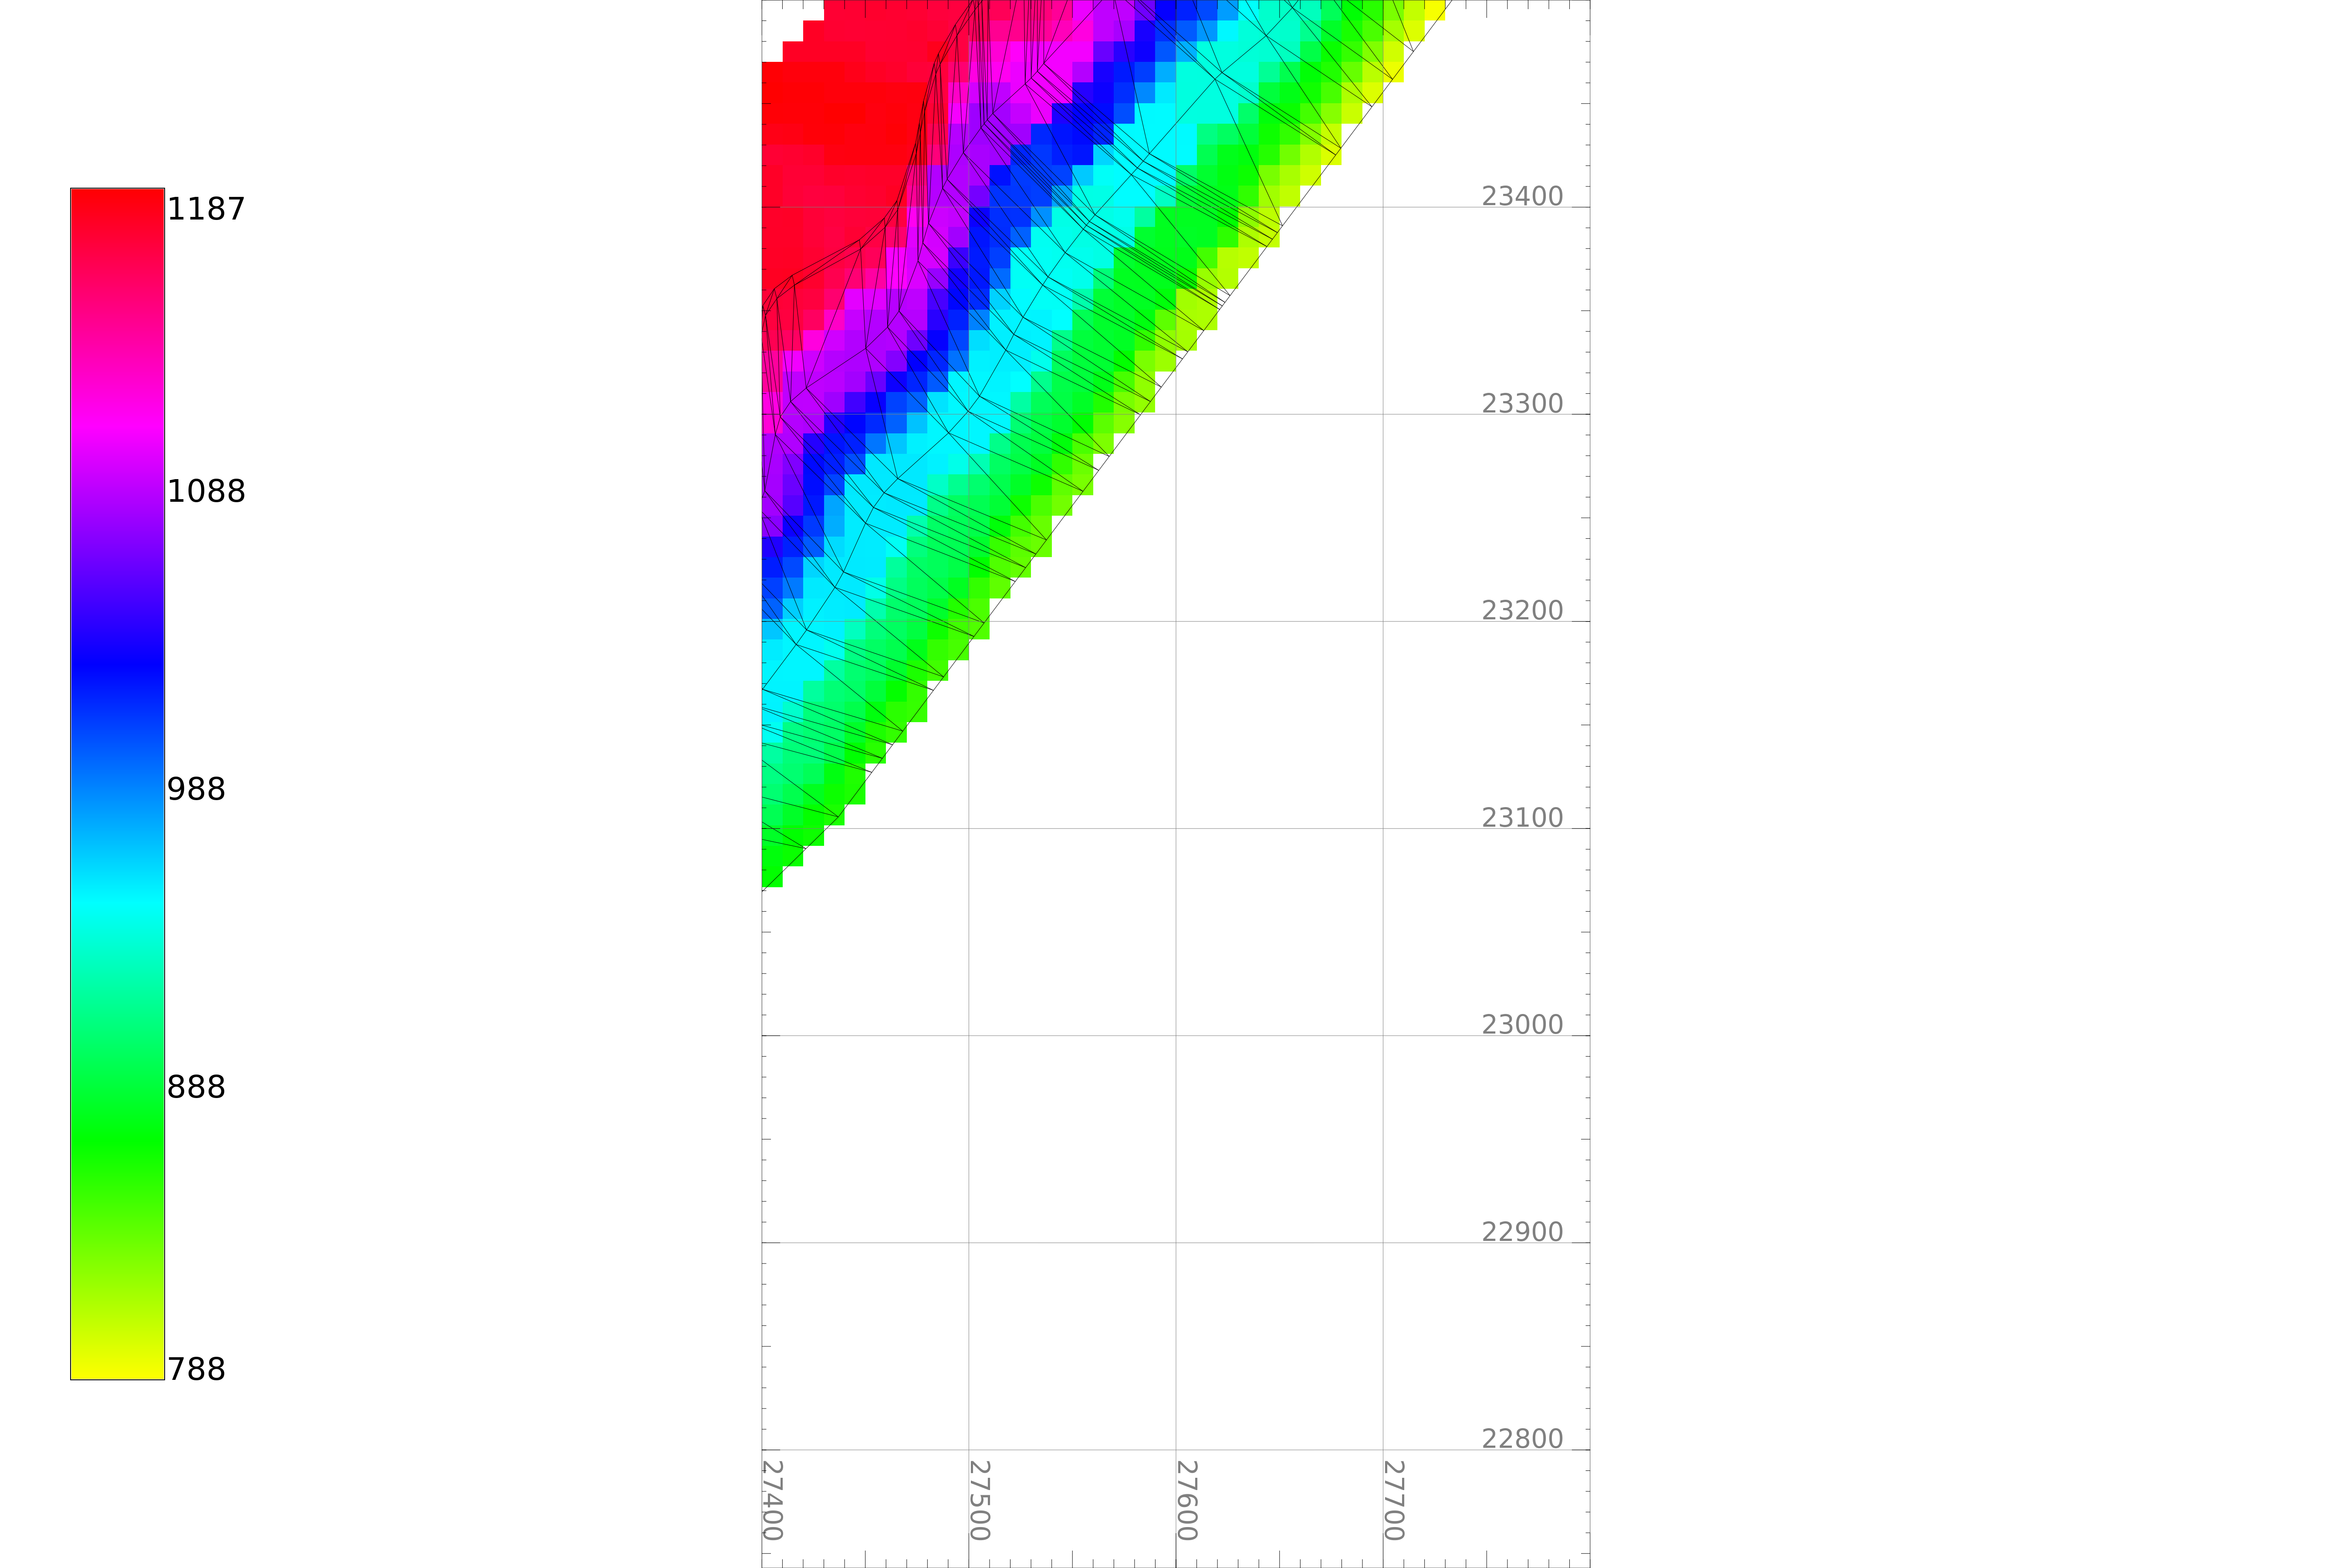

In [35]:
# display topography raster DEM
!rm map.png                                                                                 #ToDo JK: pythonize
read_grass("d.mon", select='cairo', flags='r')  #release current display monitor
read_grass("d.mon", start='cairo', resolution=5, width=1080, height=720, overwrite=True)

read_grass("d.rast", map=surfaces_rast_[2], bgcolor='white', flags='n')

read2_command("d.vect", map=surfaces_vect[2], color='black')

#show legend and grid, display result
read_grass("d.legend", raster=surfaces_rast[2], fontsize='72')[1]
read_grass("d.grid", size=100, fontsize=60)[0]
Image(filename="map.png")

In [36]:
#!r.out.gdal input=surfaces_rast output=surfaces_rast.png format=PNG  #error with libpng
!r.out.gdal input=surface_rast_3 output=surface_rast_3.tif  #output file seems ok & mask is applied

Checking GDAL data type and nodata value...
   2%   5%   9%  13%  17%  21%  25%  28%  31%  34%  38%  42%  46%  50%  53%  56%  59%  63%  67%  71%  75%  78%  81%  84%  88%  92%  96% 100%
Using GDAL data type <Float64>
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2%   5%   9%  13%  17%  21%  25%  28%  31%  34%  38%  42%  46%  50%  53%  56%  59%  63%  67%  71%  75%  78%  81%  84%  88%  92%  96% 100%
r.out.gdal complete. File <surface_rast_3.tif> created.


In [37]:
!file surface_rast_3.tif


surface_rast_3.tif: TIFF image data, little-endian, direntries=17, height=76, bps=64, compression=none, PhotometricIntepretation=BlackIsZero, width=40


## determine raster below an x,y,z point

In [38]:
def parse_grass_out(out):
# converts grass output string from grass "r.what" to a numpy array of float values
    out2 = out.replace('\n','')
    print(out2)
    out3 = np.array(out2.split(','))
    print(out3)
    out4 = np.delete(out3,2)
    print(out4)    
    # return float values of string values
    return(out4.astype(np.float))
    

In [39]:
# coordinates of a test point

xx = 27600
yy= 23400
zz = 1050

# xx = 27700
# yy= 23340
# zz = 1050

# xx = 27600
# yy= 23200
# zz = 1050

In [40]:
lithologies

['sandstone_K1ob2', 'siltstone_K1ob1', 'sandstone_K1kz']

In [41]:
def what_lithology(x, y, z):
    '''Find lithology at a point
    
    Surfaces and litholgies must be previously defined and ordered from top to bottom.
    Surfaces are the contact surface between two geological layers
    Litholgies correspond to downside layer litholgy of a surface.

    Args:
        x,y,z - coordinates of a point
        
    Requires:
        lithologies - list of lithologies
        surfaces_rast_ - list of grass masked surface rasters

    Returns:
        lithology of nearest contact surface below point x,y,z
        'NaN' if no contact surface is below point x,y,z

    '''
    
    coords=(x,y)
    z_out = []
    lithology_z = 'NaN'
    
    # get z of each layer at point x,y 
    # parse grass output to return a numpy array of float values
    for surface in surfaces_rast_:
        z_out.append(parse_grass_out(
                       read_grass("r.what", map=surface, separator=',', null_value='NaN', 
                                  coordinates=coords)[0]))
                       # consider calling multiple maps and/or multiple points (see r.what doc)
                       # to speed up execution                                                      #ToDo JK

    ## sort layers by z (bottom to top sorting)
    #z_out_ = np.sort(z_out, axis=0)  #this works, but only because x an y in each record or the same
    #                                 #look for a more universal sorting method                      #ToDo JK
    z_out_ = np.array(z_out)
    print(z_out_, '\n')

    # locate lithology for a point x,y,z considering all geological layers  
    for surface, lithology in zip(z_out_, lithologies):
        # loop through layers from bottom to top
        # requires 'layer' and 'layer_lithology' both sorted from bottom to top
        print('\n', surface)
        print(surface[2])
        print(lithology)
        if np.isnan(surface[2]):
            print("nan !!!")
            # layer does not extend to point
            # skip to next layer
            continue
        elif surface[2] > zz:
            # layer is below elevation z of point and is a candidate layer for point
            lithology_z = lithology
        else:
            # surface is at or below elevation z of point and is not a candidate surface for point
            # therefore point lies in previously set 'lithology_z = layer_lithology'
            # break out of 'for loop'
            print("break !!!")
            break
        
    return(lithology_z) 

In [42]:
lithology_z = what_lithology(xx, yy, zz)
print('\n', 'litholgy: ', lithology_z)    

27600,23400,,NaN
['27600' '23400' '' 'NaN']
['27600' '23400' 'NaN']
27600,23400,,1106.73
['27600' '23400' '' '1106.73']
['27600' '23400' '1106.73']
27600,23400,,878.4436
['27600' '23400' '' '878.4436']
['27600' '23400' '878.4436']
[[27600.     23400.            nan]
 [27600.     23400.      1106.73  ]
 [27600.     23400.       878.4436]] 


 [27600. 23400.    nan]
nan
sandstone_K1ob2
nan !!!

 [27600.   23400.    1106.73]
1106.73
siltstone_K1ob1

 [27600.     23400.       878.4436]
878.4436
sandstone_K1kz
break !!!

 litholgy:  siltstone_K1ob1


In [46]:
# # testing excution speed  
# #   74 sec for 1000 points and for 2 layers
# #   99% for grass r.what
# zzz = np.linspace(1080, 1200, num=1000)
# lithology_z = []
# for zz in zzz:
#     lithology_z.append(what_lithology(xx, yy, zz))

# lithology_z    